# _Paper Title_

## Data Generation and Clustering in Python

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.utils import shuffle
import sklearn
from scipy.stats import skewnorm
import scipy

# Outline versions used in this demo
print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("SK-Learn:", sklearn.__version__)
print("SciPy:", scipy.__version__)

matplotlib.style.use('ggplot')

Pandas: 0.22.0
NumPy: 1.15.4
Matplotlib: 2.1.2
SK-Learn: 0.19.1
SciPy: 1.1.0


## Build the dataset

For the purpose of demonstration we need some data to work with. Clustering is easiest to conceptualize in two dimensions, as it makes it very clear how your data are grouped. Below is some code that can randomly generate data in different groups. To make things a little more flexible, skew has been introduced to the distributions and the standard deviation is randomly assigned. All you need to do is pick the mean of the sample. 

In [15]:
def gen_data(centers):
    ''' Generates a random dataset with n numbers of different clusters'''
    
    data = pd.DataFrame({'x': [], 'y': [], 'z': []})
    
    offsets_x = np.random.uniform(0, 2, len(centers))
    offsets_y = np.random.uniform(0, 2, len(centers))
    
    for i in range(len(centers)):
        # Get the scale
        x_scale = np.random.uniform(1, 3) * offsets_x[i]
        y_scale = np.random.uniform(1, 3) * offsets_y[i]
        
        # Make an adjustment to ensure the sd isn't too small
        x_scale = x_scale if x_scale >= .5 else .5
        y_scale = y_scale if y_scale >= .5 else .5
            
        # Get the skew
        x_alpha = np.random.uniform(0, 10) * offsets_x[i]
        y_alpha = np.random.uniform(0, 10) * offsets_y[i]
        
        # Build x and y data
        df = pd.DataFrame({
            'x' : skewnorm.rvs(x_alpha, loc=centers[i][0], scale=x_scale, size=500),
            'y' : skewnorm.rvs(y_alpha, loc=centers[i][1], scale=y_scale, size=500),
            'z' : np.array(i).repeat(500)})
        
        data = data.append(df)
    
    return shuffle(data)

# This set of colors will also be used throughout the notebook for visualization purposes
color_map = ['red', 'green', 'blue', 'purple', 'black', 'grey', 'lawngreen', 
             'darkslategray', 'darkgreen', 'lightseagreen', 'royalblue',
             'rosybrown', 'orange', 'greenyellow', 'lime', 'darkred',
             'lime', 'darkolivegreen', 'goldenrod', 'darkcyan']

# K-Means

## Generate Data and Visualize 2 clusters

Let's start simple. To understand this concept, let's make a dataset with 2 distinct samples. We're going to chose two centers:
 - x = 2, y = 7
 - x = 7, y = 2

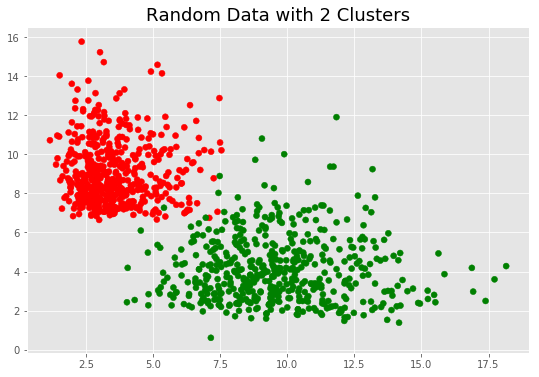

In [18]:
# Set a random seed for reporudcibility
np.random.seed(0)

# Set the centers - These can be 
centers = [(2,7), (7,2)]

# Generate the data
data_2 = gen_data(centers)

# Write out the data to a csv
data_2.to_csv('data_2.csv', index=False)

# Assign the z values to a color
c = [color_map[int(i)] for i in data_2.z.tolist()]

# Plot it
plt.figure(figsize=(9,6))
plt.scatter(data_2.x, data_2.y, color=c)
plt.title("Random Data with 2 Clusters", size=18)
fig = plt.gcf()
fig.savefig('Python_Original_2.png')
plt.show()

Great! Look at that. We have two clear groups of data. Now we can start to play. Let's use K-means to see if we can predict those centers.

Centers:
 [[9.70550897 4.06574646]
 [3.59959631 9.04532532]]


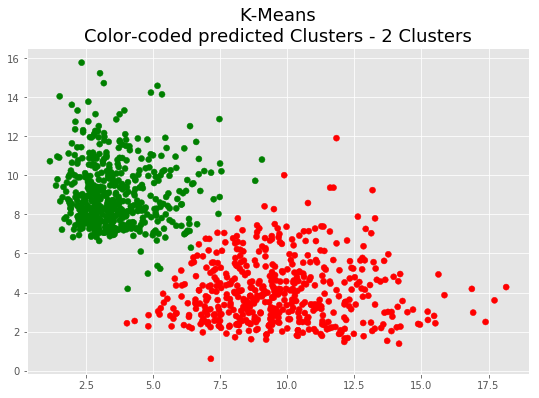

In [19]:
# Separate the labels and the data
train = data_2[['x', 'y']]
labels = data_2['z']

# Create the K-means cluster object 
km = KMeans(n_clusters=2)
km.fit(train)

# Get the centroids
centers = km.cluster_centers_

print("Centers:\n", centers)

# Get the points for each cluster
predicted = km.predict(train)

# Check how we did
# Assign the predicted values to a color
c = [color_map[int(i)] for i in predicted] # Note the change here of using predicted instead of the Z variable

# Plot it
plt.figure(figsize=(9,6))
plt.scatter(data_2.x, data_2.y, color=c)
plt.title("K-Means\nColor-coded predicted Clusters - 2 Clusters", size=18)
fig = plt.gcf()
fig.savefig('Python_K_pred_2.png')
plt.show()

You can see here that for the most part, the predictions were successful. The centroids of the clusters are slightly different, but they're reasonably close to the distributions we assigned. There's some slight misclassification in the boundaries between the red and green groups, which is understandable. Overall - the predictions were very successful. 

Now - let's get a better understanding of how these values are being predicted. K-means is going to assign a data point to the nearest centroid. To visualize this, we can draw a circle around the centroid to look at the how close each datapoint is to it's assigned cluster.

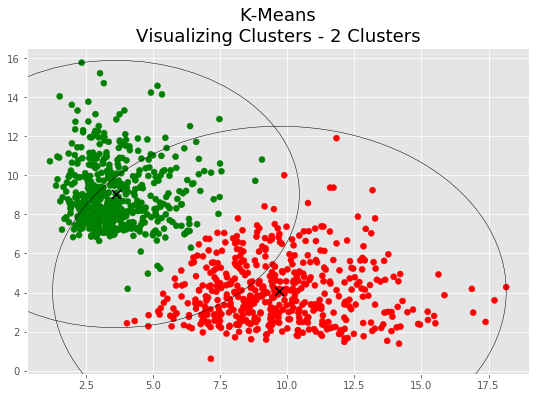

In [20]:
# Get the distance to the closest centroid
# What's happening here is that km.transform is giving us the distance to each of the 
# two centroids - so we're taking the smallest of those two distances, as that's the centroid
# to which a pair of datapoints is assigned
clust_dist = [min(x) for x in km.transform(train)]

# Identify the max distance for each cluster
max_dist = np.zeros(2) # Initialize 0 as initial distance to compare

# Loop over each pair of data points, and evaluate the distance to the cluster
# Collect the largest as that's going to ultimately be our radius
for i in range(len(train)):
    # Pick out which label was assigned
    label = predicted[i]
    
    # Check if this distance is larger than the max distance
    if clust_dist[i] > max_dist[label]:
        # If the distance is farther, assign as the max distance for that label
        max_dist[label] = clust_dist[i]

# Plot the scatter plot
plt.figure(figsize=(9,6))
plt.scatter(data_2.x, data_2.y, color=c)
plt.title("K-Means\nVisualizing Clusters - 2 Clusters",size=18)

# Get the figure info because we need to draw the centroid and a circl
fig = plt.gcf()
ax = plt.gca()

# Build the circles
for i in range(len(centers)):
    # Scatterplot the centroid - so just plotting one point
    plt.scatter(centers[i][0], centers[i][1], marker='x', s=80, color='black', alpha=1)
    # ------------------------|   X axis   |    Y Axis     |    Radius  |     No fill     |     Ring color     |
    ax.add_artist(plt.Circle((centers[i][0], centers[i][1]), max_dist[i], facecolor='None', edgecolor='black'))
    
fig = plt.gcf()
fig.savefig('Python_K_pred_circles_2.png')

## Generate Data and Visualize 6 clusters

Let's make things a little more complicated now and spice up our dataset. Let's make some more groups of data.
 - x = 2, y = 7
 - x = 7, y = 2
 - x = 10, y = 12
 - x = 13, y = 0
 - x = 1, y = 10
 - x = 1, y = 1

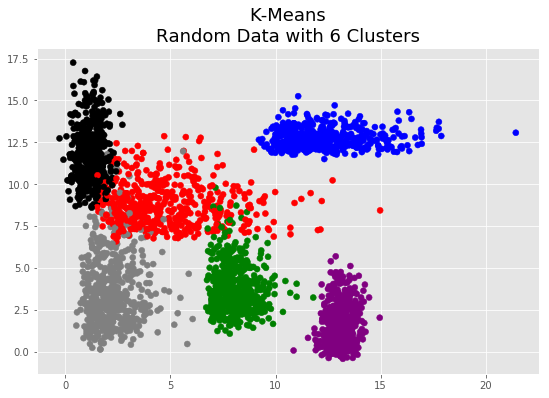

In [22]:
# Set a random seed for reporudcibility
np.random.seed(6)

# Set the centers - These can be 
centers = [(2,7), (7,2), (10,12), (13,0), (1,10), (1,1)]

# Generate the data
data_6 = gen_data(centers)

# Write out the data to a csv
data_6.to_csv('data_6.csv', index=False)

# Assign the z values to a color
c = [color_map[int(i)] for i in data_6.z.tolist()]

# Plot it

plt.figure(figsize=(9,6))
plt.scatter(data_6.x, data_6.y, color=c)
plt.title("K-Means\nRandom Data with 6 Clusters", size=18)
fig = plt.gcf()
fig.savefig('Python_Original_6.png')
plt.show()

Now let's go ahead and predict the clusters and visualize how K-means is goign to make those decisions again.

Centers:
 [[ 1.30871154 11.72308601]
 [ 8.0907629   3.81038679]
 [12.17115681 12.65926635]
 [ 4.40554158  8.46152323]
 [13.09093221  1.6279105 ]
 [ 2.1532958   3.04194748]]


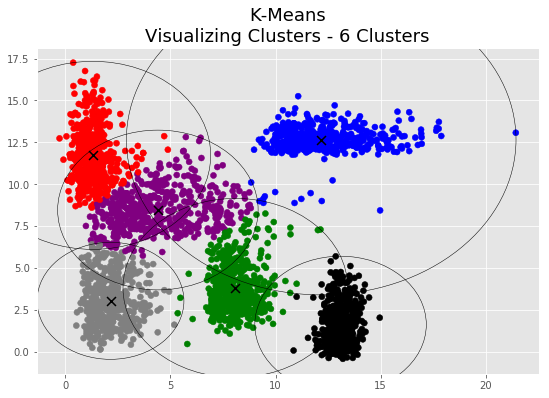

In [23]:
# Separate the labels and the data
train = data_6[['x', 'y']]
labels = data_6['z']

# Create the K-means cluster object 
km = KMeans(n_clusters=6)
km.fit(train)

# Get the centroids
centers = km.cluster_centers_

print("Centers:\n", centers)

# Get the points for each cluster
predicted = km.predict(train)

# Check how we did
# Assign the predicted values to a color
c = [color_map[int(i)] for i in predicted] # Note the change here of using predicted instead of the Z variable

# Get the distance to the closest centroid
# What's happening here is that km.transform is giving us the distance to each of the 
# two centroids - so we're taking the smallest of those two distances, as that's the centroid
# to which a pair of datapoints is assigned
clust_dist = [min(x) for x in km.transform(train)]

# Identify the max distance for each cluster
max_dist = np.zeros(6) # Initialize 0 as initial distance to compare

# Loop over each pair of data points, and evaluate the distance to the cluster
# Collect the largest as that's going to ultimately be our radius
for i in range(len(train)):
    # Pick out which label was assigned
    label = predicted[i]
    
    # Check if this distance is larger than the max distance
    if clust_dist[i] > max_dist[label]:
        # If the distance is farther, assign as the max distance for that label
        max_dist[label] = clust_dist[i]

# Plot the scatter plot
plt.figure(figsize=(9,6))
plt.scatter(data_6.x, data_6.y, color=c)
plt.title("K-Means\nVisualizing Clusters - 6 Clusters",size=18)

# Get the figure info because we need to draw the centroid and a circl
fig = plt.gcf()
ax = plt.gca()

# Build the circles
for i in range(len(centers)):
    # Scatterplot the centroid - so just plotting one point
    plt.scatter(centers[i][0], centers[i][1], marker='x', s=80, color='black', alpha=1)
    # ------------------------|   X axis   |    Y Axis     |    Radius  |     No fill     |     Ring color     |
    ax.add_artist(plt.Circle((centers[i][0], centers[i][1]), max_dist[i], facecolor='None', edgecolor='black'))
    
fig = plt.gcf()
fig.savefig('Python_6_pred_circles.png')

# Hierarchical Clustering

Now let's look at a differnet method - Hiearachical clustering. Hierarchical clustering works differently than K-means. There are two approaches for hierarchical clustering: agglomerative and divisive. Agglomerative initially looks at each datapoint as its own cluster, and divisive looks at the entire set of data as its own cluster. In this demonstration, we'll focus on agglomerative. 

Starting with each individual datapoint as a cluster, agglomerative hierarchical clustering will work backwards, taking the "nearest neighbor" to group datapoints (using some distance metric, i.e. euclidian distance) into larger clusters until you have one big cluster at the end. At that point, you can use a dendogram do decide on optimal number of clusters for your problem. 

Given that this is agglomerative clustering, start from the bottom of the dendogram up. Each cluster is indicated by a U shaped link. The legs of the U represent each of the individual clusters, and as the hierarchical clustering processes, the U represents the two clusters that were merged. The length of the legs in the U shaped link represent the distance between those clusters. For more information on the dendogram represented in this example, check [this link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram). Another significant factor of hierarchical clustering is the linkage method. For more information on this, reference our paper. In all of the following examples, we will be using Ward's method. 

Let's look at an example.

_Note: the code used below originated in the article [here](https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/)_

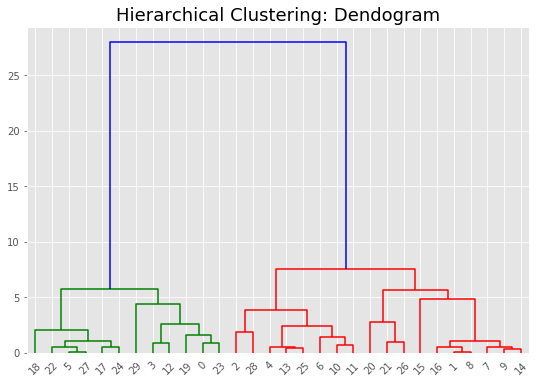

In [24]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

# Subset the dataset to a reasonable size for visualization
subset = data_2.iloc[0:30]

# Establish the linking
linked = linkage(subset, 'ward')

# X tick labels
labelList = range(len(subset))

# Make the figure
plt.figure(figsize=(9, 6))  

# Draw the dendogram
dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.title("Hierarchical Clustering: Dendogram", size=18)
fig = plt.gcf()
fig.savefig('Python_dendogram.png')
plt.show()  

Looking at this example we can fairly clearly see that optimally, we have two clusters in the dataset. Look at the top link - the legs of the U are much longer than the two clusters beneath it, and from there on the legs are quite short.

Let's use this method on the full dataset and see how it does.

_Note: Here I'm moving back to using the sklearn module, despite the last example using scipy. Scipy offerred the dendogram visualization, while sklearn offers the extremely portable API that allows me to use the same code from the K-means example with minimal changes._

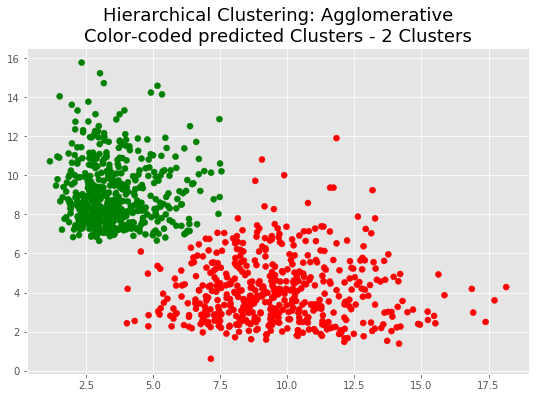

In [25]:
# Separate the labels and the data
train = data_2[['x', 'y']]
labels = data_2[['z']]

hc = AgglomerativeClustering(n_clusters=2)
hc.fit(train)

# Get the points for each cluster
predicted = hc.labels_

# Check how we did
# Assign the predicted values to a color
c = [color_map[int(i)] for i in predicted] # Note the change here of using predicted instead of the Z variable


# Plot it
plt.figure(figsize=(9,6))
plt.scatter(data_2.x, data_2.y, color=c)
plt.title("Hierarchical Clustering: Agglomerative\nColor-coded predicted Clusters - 2 Clusters", size=18)
fig = plt.gcf()
fig.savefig('Python_HC_pred_2.png')
plt.show()

Another point to take notice of in this example is that we're not given centroids to the clusters like with K-Means. This is because the approach is fundamentally different; instead of measuring the distance from teh center of the cluster, this method analayzes the distance from individual points - and this method differs based on the linkage method. 

Let's look at the same approach using the 6 group dataset.

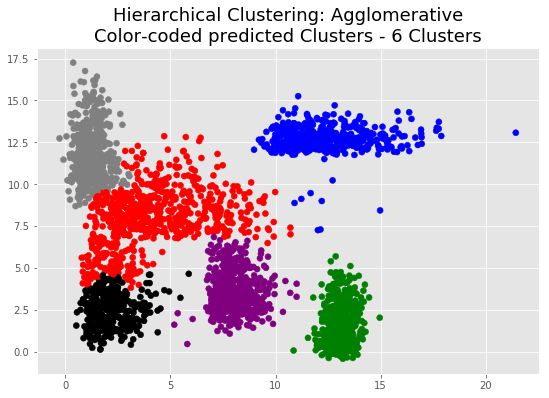

In [26]:
# Separate the labels and the data
train = data_6[['x', 'y']]
labels = data_6[['z']]

hc = AgglomerativeClustering(n_clusters=6)
hc.fit(train)

# Get the points for each cluster
predicted = hc.labels_

# Check how we did
# Assign the predicted values to a color
c = [color_map[int(i)] for i in predicted] # Note the change here of using predicted instead of the Z variable


# Plot it
plt.figure(figsize=(9,6))
plt.scatter(data_6.x, data_6.y, color=c)
plt.title("Hierarchical Clustering: Agglomerative\nColor-coded predicted Clusters - 6 Clusters", size=18)
fig = plt.gcf()
fig.savefig('Python_HC_pred_6.png')
plt.show()

Note that K-Means did a better job at assigning datapoints to the right group in this example. Of course, these are using default settings for the clustering objects, so hyperparameters could be fine tuned to do a better job. Overall, it's up to you to take the time to ensure that you're choosing the best method applicable to your use case.

Now let's move over to look at clustering in R. 